In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append('../lib/')
import matplotlib.pyplot as plt
from find_stars_isolated import *
from astropy.modeling import models, fitting
from utils import get_fits_file, latex_settings

In [2]:
filepath_data = '../Data/FITS/'
wavelen='F606w'
# Get images as 2-D numpy array from FITS file of F606w
fits_f606, image_f606 = get_fits_file(wavelen=wavelen, fits_path=filepath_data)

# info about F606w fits file
fits_f606.info()

Filename: ../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_F606w_v1_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    7127   (10510, 10403)   float32   


In [3]:
image = image_f606.copy()

# Check how many negative values are there
print(image[image < 0].size / image.size)

# setting to 0 all negative values
image[image < 0] = 0

0.15048535457778456


In [4]:
filepath_results = '../Results/'

df = pd.read_csv(filepath_results + 'ID_coords_image_F606w_filt.csv')
df

,ID,Xcor,Ycor
0,45413,4975,1003
1,52218,3561,1067
2,57307,3041,1116
3,59517,5267,1136
4,67202,5355,1214
...,...,...,...
878,890845,6865,10194
879,892180,5579,10216
880,893600,5870,10241
881,897539,7124,10323


In [5]:
from typing import Tuple

def get_star_box(ID: int, IDs: np.ndarray = df.to_numpy(),
                    img: np.ndarray = image,
                    bb: int = 15, norm=True) -> Tuple[np.array]:
    """Get the box with the star's maximum intensity at center.

    Args:
        ID (float): star ID;
        IDs (np.ndarray, optional): ID of all isolated stars on the
                                    image. Defaults to df.to_numpy().
        img (np.ndarray, optional): data from fits file.
                                    Defaults to image.
        bb (int, optional): half side of the squared box.
                            Defaults to 15.

    Returns:
        np.array: star's box.
    """
    xc, yc = IDs[IDs[:,0] == ID, 1:].flatten()
    mat = img.copy() 
    box = mat[yc - bb:yc + bb, xc - bb: xc + bb]
    Ai = np.max(box)
    xi = xc - bb + np.where(box == Ai)[1][0]
    yi = yc - bb + np.where(box == Ai)[0][0]
    
    # check if max intensity is at central pixel
    if [xc, yc] != [xi, yi]:
        box = mat[yi - bb: yi + bb, xi - bb: xi + bb]
        xc, yc = xi, yi
    
    if norm:    
        box /= Ai
    else:
        pass
    
    return box, xc, yc, Ai

In [6]:
from psf_analysis import *
filepath = '../Results/Hubble/'
PSF = np.load(filepath + 'Hubble_pupil_PSF.npy')
OTF_shift = get_OTF_from_PSF(PSF)


def deconvolution_star(ID: int,
                        OTF_shift: np.ndarray=OTF_shift) -> np.ndarray:
    """Compute the Gaussian 2D function of a given star.

    Args:
        ID (float): star ID;
        IDs (np.ndarray, optional): ID of all isolated stars on the
                                    image. Defaults to df.to_numpy().
        img (np.ndarray, optional): data from fits file.
                                    Defaults to image.

    Returns:
        np.array: star's ID, initial guess for the fitting parameters,
                best fit parameters and mse.
    """
    box, *_ = get_star_box(ID)
    box_fft = np.fft.fft2(box)
    box_fft_shift = np.fft.fftshift(box_fft)
    
    real_obj_F = box_fft_shift / OTF_shift
    real_obj_shift = np.fft.ifft2(real_obj_F)
    real_obj = np.abs(np.fft.ifftshift(real_obj_shift))
    #r2 = r_squared(real_obj, box)
    return real_obj


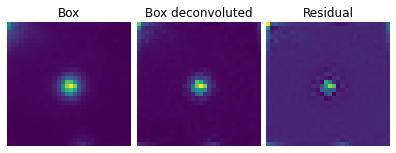

In [42]:
fig, axs = latex_settings(1, 3, 1)

ID = 859401
box, *params = get_star_box(ID)
axs[0].imshow(box)
dec = deconvolution_star(ID)
axs[1].imshow(dec)
axs[2].imshow(dec - box)
axs[0].set_title('Box')
axs[1].set_title('Box deconvoluted')
axs[2].set_title('Residual')

for ax in axs:
    ax.axis('off')

plt.savefig(f'dec_results_image_{ID}.png',
            dpi=800, transparent=1, bbox_inches='tight')

In [43]:
import matplotlib.pyplot as plt

from utils import latex_settings

def plot_fit_results(ID):
    fig, axs = latex_settings(1, 3)

    box, *param = get_star_box(ID)
    axs[0].imshow(box)
    axs[0].axis('off')
    axs[0].set_title('Box')

    fit = gauss2d_fitting(ID)
    axs[1].imshow(fit)
    axs[1].set_title('Gaussian 2D')
    
    axs[2].imshow(box - fit)
    axs[2].set_title('Residual')

    for ax in axs:
        ax.axis('off')
        
    plt.savefig('fit_results_image.png',
                dpi=800, transparent=1,  bbox_inches='tight')

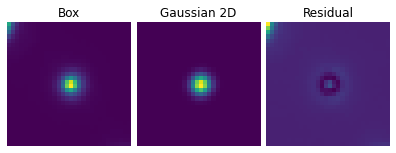

In [44]:
plot_fit_results(458309)

In [7]:
df = pd.read_csv('../Results/fit_results_F606w_gauss2d.csv')
df_bad = pd.read_csv('../Results/bad_stars_ID_F606w.txt')

mask = (df.r2 > 0.95) & ~(df.ID.isin(df_bad.bad_ID)) & (df.A < 2)

df[mask]

,ID,Ai,xi,yi,A,x0,y0,sigma_x,sigma_y,theta,r2
1,52218.0,1720.054565,3559.0,1067.0,0.989116,3559.527661,1067.453909,1.536470,1.464358,-0.501849,0.966501
12,95763.0,4824.379395,6656.0,1468.0,0.923279,6655.657205,1468.208305,1.571991,1.536281,-0.045182,0.960362
17,131475.0,1708.534668,4297.0,1749.0,0.883332,4296.737776,1749.025517,1.533743,1.491052,-0.776555,0.969919
19,139364.0,1170.704834,5047.0,1819.0,0.952026,5047.247071,1819.428381,1.509263,1.500241,-0.012465,0.969210
25,153304.0,1383.010498,6329.0,1947.0,0.896320,6328.657487,1947.098024,1.564207,1.535911,-0.267274,0.994663
...,...,...,...,...,...,...,...,...,...,...,...
861,859401.0,1464.358643,6458.0,9806.0,0.896744,6457.745982,9806.037258,1.696833,1.622330,0.025144,0.989532
866,867161.0,967.179199,4079.0,9895.0,0.894075,4079.348673,9894.909869,1.679593,1.586625,-0.255485,0.983388
867,868570.0,1211.681885,6977.0,9910.0,0.846548,6977.178137,9909.609707,1.805178,1.714130,-0.211065,0.964575
874,876309.0,1050.422363,3947.0,9997.0,0.925746,3946.474640,9997.451872,1.544675,1.484740,0.029711,0.975629


In [10]:
df

,ID,Ai,xi,yi,A,x0,y0,sigma_x,sigma_y,theta,r2
0,45413.0,976.700928,4975.0,1003.0,0.871890,4975.078626,1003.368820,1.701662,1.555486,-0.202010,0.535600
1,52218.0,1720.054565,3559.0,1067.0,0.989116,3559.527661,1067.453909,1.536470,1.464358,-0.501849,0.966501
2,57307.0,959.561279,3041.0,1116.0,0.845459,3040.864144,1116.636609,1.632058,1.554331,2.402598,0.361683
3,59517.0,1763.463379,5266.0,1137.0,0.803271,5265.884712,1136.924395,1.648372,1.525492,-0.181654,0.845659
4,67202.0,1494.275757,5354.0,1213.0,0.872993,5354.296917,1213.092089,1.577170,1.513458,-0.066725,0.919235
...,...,...,...,...,...,...,...,...,...,...,...
878,890845.0,971.496460,6865.0,10194.0,0.886282,6865.025856,10193.981069,1.699300,1.865671,0.889786,0.126838
879,892180.0,1579.990723,5577.0,10216.0,0.730657,5577.800398,10216.387447,2.348847,2.037618,-0.075431,0.956985
880,893600.0,1085.983887,5869.0,10241.0,0.760044,5869.104249,10241.733461,1.883473,1.578987,5.546246,0.844582
881,897539.0,1573.232666,7123.0,10322.0,0.910377,7123.027942,10322.104568,1.839167,1.692269,-0.510299,0.069117


In [19]:
fig, ax = latex_settings()

ax.imshow(image, cmap='gray')
ax.scatter(df.loc[mask, 'xi'], df.loc[mask, 'yi'],
           color='b', s=0.1, marker=',', label='Dataset pts')
ax.scatter(df.loc[mask, 'xi'], df.loc[mask, 'yi'], alpha=0.4,
           marker='o', color='r', fc='None', s=6., label='Image pts')
ax.axis('off')
filepath_images = '../Images/'
plt.savefig(filepath_images + f'stars_ID_identified_{wavelen}_final.png',
            dpi=800, transparent=True,  bbox_inches='tight')
plt.close()

In [8]:
%matplotlib widget
filepath_images = '../Images/'

for ID in df[mask].ID[73:]:
    dec = deconvolution_star(ID)
    plt.imshow(dec)
    plt.savefig(filepath_images + f'Deconvolution/dec_{ID}.png',
                dpi=800, transparent=True)
    plt.clf()
    plt.close()